In [25]:
using LinearAlgebra
using Graphs
using MetaGraphs
using DataStructures
using Plots
using SymPy

# =============================================================================
# Graph Construction (Node Creation and Edge Functions)
# =============================================================================

"""
    mutable struct GraphConstructionDiscretization

Holds the parameters for the graph (e.g. QZ circles, start/goal, UAV parameters)
and later the computed node positions.
"""
mutable struct GraphConstructionDiscretization
    map_qz::Vector{Tuple{Float64,Float64,Float64}}
    start::Tuple{Float64,Float64}
    goal::Tuple{Float64,Float64}
    q_min::Float64
    q_max::Float64
    q_act::Float64
    alpha::Float64
    beta::Float64
    discretization_angle::Float64
    node_positions::Array{Float64,2}
end

# Constructor initializes node_positions as an empty array.
function GraphConstructionDiscretization(map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discretization_angle)
    return GraphConstructionDiscretization(map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discretization_angle, zeros(0,0))
end

"""
    create_nodes(g::GraphConstructionDiscretization)

Discretizes the circles in `g.map_qz` and creates a node array. The start node is
assigned the key `"s"` and the goal node `"g"`. In addition, two dictionaries are
returned: one mapping each node's information tuple to its key and another with the
reverse mapping.
"""
function create_nodes(g::GraphConstructionDiscretization)
    angles = deg2rad.(0:g.discretization_angle:360)  # include 360°
    num_points_per_circle = length(angles)
    total_nodes = length(g.map_qz) * num_points_per_circle + 2
    node_positions = zeros(total_nodes, 4)
    
    # Use dictionaries to map node info → key and vice versa.
    index_map = Dict{NTuple{4,Float64}, Any}()
    reverse_index_map = Dict{Any, NTuple{4,Float64}}()
    
    # Define start and goal tuples (note: Julia tuples index from 1)
    start_tuple = (g.start[1], g.start[2], 0.0, g.q_act)
    goal_tuple  = (g.goal[1],  g.goal[2],  float(length(g.map_qz)+1), g.q_act)
    index_map[start_tuple] = "s"
    index_map[goal_tuple]  = "g"
    reverse_index_map["s"] = start_tuple
    reverse_index_map["g"] = goal_tuple
    
    # Fill in node positions for start and goal.
    node_positions[1, :] = [g.start[1], g.start[2], 0.0, g.q_act]
    node_positions[2, :] = [g.goal[1],  g.goal[2],  float(length(g.map_qz)+1), g.q_act]
    
    node_index = 3
    
    for (circle_index, (cx, cy, radius)) in enumerate(g.map_qz)
        x_vals = cx .+ radius .* cos.(angles)
        y_vals = cy .+ radius .* sin.(angles)
        for j in 1:num_points_per_circle
            node_positions[node_index, 1] = x_vals[j]
            node_positions[node_index, 2] = y_vals[j]
            node_positions[node_index, 3] = circle_index
            node_positions[node_index, 4] = g.q_act
            key = (x_vals[j], y_vals[j], float(circle_index), g.q_act)
            index_map[key] = node_index
            reverse_index_map[node_index] = key
            node_index += 1
        end
    end
    g.node_positions = node_positions
    return node_positions, index_map, reverse_index_map
end

# -----------------------------
# Helper functions for edges
# -----------------------------
function point_to_segment_distance(px, py, x1, y1, x2, y2)
    A = px - x1
    B = py - y1
    C = x2 - x1
    D = y2 - y1
    dot = A * C + B * D
    len_sq = C^2 + D^2
    param = len_sq == 0 ? -1 : dot / len_sq
    if param < 0
        xx, yy = x1, y1
    elseif param > 1
        xx, yy = x2, y2
    else
        xx, yy = x1 + param * C, y1 + param * D
    end
    dx = px - xx
    dy = py - yy
    return sqrt(dx^2 + dy^2)
end

function line_segment_intersects_circle(g::GraphConstructionDiscretization, circle::Tuple{Float64,Float64,Float64},
                                        point1::Tuple{Float64,Float64}, point2::Tuple{Float64,Float64})
    (center_x, center_y, radius) = circle
    (x1, y1) = point1
    (x2, y2) = point2
    return point_to_segment_distance(center_x, center_y, x1, y1, x2, y2) < radius
end

# Compute feasibility, λ and segment information (translated from Python logic).
function compute_edge_parameters(g::GraphConstructionDiscretization, soc_i, soc_j, distance)
    feasible = false
    line_segment = Dict{String, Tuple{Float64,Float64}}()
    if soc_j > min(g.q_max, soc_i + g.beta * distance)
        return feasible, nothing, line_segment
    elseif (soc_i - g.alpha * distance) < g.q_min && (soc_j <= soc_i - g.alpha * distance)
        feasible = true
        lamb = 1.0
        line_segment["e"] = (0.0, lamb)
    else
        lamb_1 = (g.q_max - soc_i) / (g.beta * distance)
        lamb_2 = (g.q_max - soc_j) / (g.alpha * distance)
        if lamb_1 >= 0 && lamb_2 >= 0 && (lamb_1 + lamb_2 <= 1)
            lamb = lamb_1 + g.alpha/(g.beta+g.alpha) * (1 - lamb_1 - lamb_2)
            lamb_2_sw = lamb_2 + g.beta/(g.beta+g.alpha) * (1 - lamb_1 - lamb_2)
            line_segment["g"] = (0.0, lamb_1)
            line_segment["e"] = (lamb_1, lamb_2_sw)
            line_segment["g2"] = (lamb_2_sw, 1.0)
        else
            lamb = (soc_j - soc_i + g.alpha * distance) / ((g.alpha + g.beta) * distance)
            line_segment["g"] = (0.0, lamb)
            line_segment["e"] = (lamb, 1.0)
        end
        if 0 <= lamb <= 1
            feasible = true
        end
    end
    return feasible, lamb, line_segment
end

# Using MetaGraphs we add edge properties. (Edges will be added "in place" in the MetaDiGraph.)
function external_edge_addition(g::GraphConstructionDiscretization, i, node_i, j, node_j, mg::MetaDiGraph)
    # Convert tuple slices to vectors before subtracting
    distance = norm([node_i[1], node_i[2]] - [node_j[1], node_j[2]])
    soc_i = node_i[4]
    soc_j = node_j[4]
    feasible, lamb, line_segment = compute_edge_parameters(g, soc_i, soc_j, distance)
    if feasible
        cost = lamb * distance
        # Convert i and j to proper vertex indices
        src_vertex = (i == "s") ? 1 : (i == "g") ? 2 : i
        dst_vertex = (j == "s") ? 1 : (j == "g") ? 2 : j
        add_edge!(mg, src_vertex, dst_vertex)  # Now both are integers
        set_prop!(mg, src_vertex, dst_vertex, :node_i_info, node_i)
        set_prop!(mg, src_vertex, dst_vertex, :node_j_info, node_j)
        set_prop!(mg, src_vertex, dst_vertex, :line_segment, line_segment)
        set_prop!(mg, src_vertex, dst_vertex, :fuel_cost, cost)
        set_prop!(mg, src_vertex, dst_vertex, :risk_cost, 0.0)
        set_prop!(mg, src_vertex, dst_vertex, :feasibility, feasible)
        set_prop!(mg, src_vertex, dst_vertex, :edge_type, "external")
    end
end

function internal_edge_addition(g::GraphConstructionDiscretization, i, node_i, j, node_j, mg::MetaDiGraph)
    # Convert tuple slices to vectors before subtracting
    distance = norm([node_i[1], node_i[2]] - [node_j[1], node_j[2]])
    soc_i = node_i[4]
    soc_j = node_j[4]
    circle = g.map_qz[Int(node_i[3])]
    (_, _, radius) = circle
    x = radius^2 - (distance/2)^2
    pen_dist = sqrt(max(x,0))

    feasible, lamb, line_segment = compute_edge_parameters(g, soc_i, soc_j, distance)
    if feasible
        cost = lamb * distance
        risk_cost = risk_cost_cal(g, line_segment, pen_dist, distance)
        # Convert i and j to proper vertex indices
        src_vertex = (i == "s") ? 1 : (i == "g") ? 2 : i
        dst_vertex = (j == "s") ? 1 : (j == "g") ? 2 : j
        add_edge!(mg, src_vertex, dst_vertex)  # Now both are integers
        set_prop!(mg, src_vertex, dst_vertex, :node_i_info, node_i)
        set_prop!(mg, src_vertex, dst_vertex, :node_j_info, node_j)
        set_prop!(mg, src_vertex, dst_vertex, :line_segment, line_segment)
        set_prop!(mg, src_vertex, dst_vertex, :fuel_cost, cost)
        set_prop!(mg, src_vertex, dst_vertex, :risk_cost, risk_cost)
        set_prop!(mg, src_vertex, dst_vertex, :feasibility, feasible)
        set_prop!(mg, src_vertex, dst_vertex, :edge_type, "internal")
    end
end

function risk_cost_cal(g::GraphConstructionDiscretization, line_segment::Dict{String, Tuple{Float64,Float64}}, pen_dist, distance)
    risk_cost = 0.0
    constant_factor = 30.0
    for (key, (lamb_start, lamb_end)) in line_segment
        if key == "e"
            continue
        elseif startswith(key, "g")
            if lamb_start <= 0.5 && lamb_end >= 0.5
                risk_cost += abs(1/(pen_dist+0.01) *
                    (atan((distance/2 - lamb_start*distance)/(pen_dist+0.01)) +
                     atan((lamb_end*distance - distance/2)/(pen_dist+0.01))))
            elseif lamb_start >= 0.5
                risk_cost += abs(1/(pen_dist+0.01) *
                    (atan((lamb_end*distance - distance/2)/(pen_dist+0.01)) -
                     atan((lamb_start*distance - distance/2)/(pen_dist+0.01))))
            elseif lamb_end <= 0.5
                risk_cost += abs(1/(pen_dist+0.01) *
                    (atan((distance/2 - lamb_start*distance)/(pen_dist+0.01)) -
                     atan((distance/2 - lamb_end*distance)/(pen_dist+0.01))))
            end
        end
    end
    return constant_factor * risk_cost
end

risk_cost_cal (generic function with 1 method)

In [26]:
# =============================================================================
# Main Pipeline
# =============================================================================

# Define constants and initial conditions.
map_qz = [(0.0, 0.0, 6.0), (12.0, 10.0, 4.0)]
start = (-5.0, -5.0)
goal = (15.0, 15.0)
alpha = 0.5
recharge_factor = 2.0
beta = alpha / recharge_factor
q_min, q_max, q_act = 20.0, 100.0, 50.0
discretization_angle = 10.0

10.0

In [27]:
# Instantiate the graph-construction object and create nodes.
g = GraphConstructionDiscretization(map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discretization_angle)
nodes, index_map, reverse_index_map = create_nodes(g)

# Create a directed meta-graph with a number of vertices equal to the number of nodes.
num_vertices = length(reverse_index_map)
mg = MetaDiGraph(num_vertices)

# Set vertex properties (here we store the node information).
for (key, node_info) in reverse_index_map
    # Here we assume that if the key is "s" then we assign it to vertex 1,
    # if "g" then vertex 2, else the key is an integer.
    vertex = key == "s" ? 1 : key == "g" ? 2 : key
    set_prop!(mg, vertex, :node_info, node_info)
end

# Build the visibility graph by adding edges.
keys_list = collect(keys(reverse_index_map))
for i in keys_list
    for j in keys_list
        if i == j
            continue
        end
        node_i = reverse_index_map[i]
        node_j = reverse_index_map[j]
        # Extract coordinates and circle info.
        x_i, y_i = node_i[1], node_i[2]
        x_j, y_j = node_j[1], node_j[2]
        circle_i = node_i[3]
        circle_j = node_j[3]
        if circle_i == circle_j && circle_i != 0.0 && circle_j != float(length(map_qz)+1)  # Check for non-start/goal
            internal_edge_addition(g, i, node_i, j, node_j, mg)
        else
            # Skip checking intersections for connections with start/goal if needed
            intersection_exists = false
            for circle in map_qz
                if line_segment_intersects_circle(g, circle, (x_i, y_i), (x_j, y_j))
                    intersection_exists = true
                    break
                end
            end
            if !intersection_exists
                external_edge_addition(g, i, node_i, j, node_j, mg)
            end
        end
    end
end

# Assign heuristic costs to each vertex (based on Euclidean distance to goal).
goal_node = (goal[1], goal[2], float(length(map_qz)+1), q_act)
for i in keys_list
    node = reverse_index_map[i]
    dist = sqrt((goal_node[1] - node[1])^2 + (goal_node[2] - node[2])^2)  # Changed SymPy.sqrt to sqrt
    heuristic_cost = (alpha/(alpha+beta)) * dist
    vertex = i == "s" ? 1 : i == "g" ? 2 : i
    set_prop!(mg, vertex, :heuristic_cost, heuristic_cost)
end

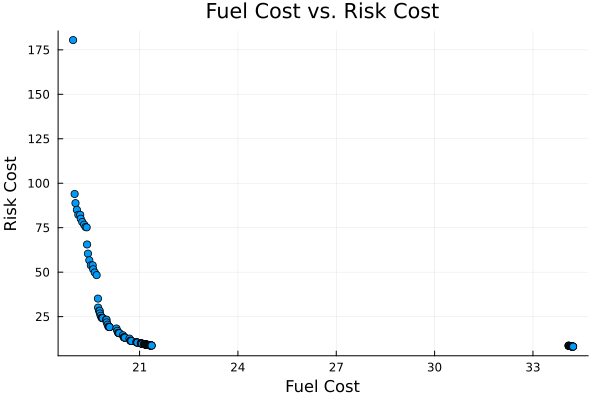

Elapsed time: 0.2750495 seconds


In [ ]:
# =============================================================================
# Biobjective Search (Using a Priority Queue)
# =============================================================================
BOA_elapsed = @elapsed begin
    # Define a simple mutable structure for search nodes.
    mutable struct SearchNode
        f1::Float64
        f2::Float64
        g1::Float64
        g2::Float64
        state::Any  # This can be Int64 or String
    end

    # For ordering in the priority queue we use f1 (you can extend this as needed).
    function Base.isless(a::SearchNode, b::SearchNode)
        return a.f1 < b.f1
    end

    # We need to make SearchNode hashable for use in PriorityQueue
    function Base.hash(n::SearchNode, h::UInt)
        return hash((n.f1, n.f2, n.g1, n.g2, n.state), h)
    end

    function Base.:(==)(a::SearchNode, b::SearchNode)
        return a.f1 == b.f1 && a.f2 == b.f2 && a.g1 == b.g1 && a.g2 == b.g2 && a.state == b.state
    end

    # Create a priority queue with SearchNode objects
    pq = PriorityQueue{SearchNode, Float64}()
    start_node = SearchNode(0.0, 0.0, 0.0, 0.0, "s")
    pq[start_node] = start_node.f1

    # Initialize solution and cost dictionaries.
    sols = Dict{Any, Vector{SearchNode}}()
    g2_min = Dict{Any, Float64}()
    for state in keys_list
        sols[state] = SearchNode[]
        g2_min[state] = Inf
    end
    reduce_factor = 1.0

    while !isempty(pq)
        current_node = dequeue!(pq)
        
        # Convert state to vertex ID for graph operations
        current_vertex = current_node.state == "s" ? 1 : 
                        current_node.state == "g" ? 2 : current_node.state
        
        # Check for dominance and update solutions
        if current_node.g2 >= reduce_factor * g2_min[current_node.state] || 
        current_node.f2 >= reduce_factor * g2_min["g"]
            continue
        end
        
        g2_min[current_node.state] = current_node.g2
        push!(sols[current_node.state], current_node)
        
        if current_node.state == "g"
            continue
        end
        
        # Expand successors (neighbors from the meta-graph)
        for neighbor_vertex in outneighbors(mg, current_vertex)
            # Convert neighbor vertex ID back to state representation
            neighbor_state = neighbor_vertex == 1 ? "s" : 
                            neighbor_vertex == 2 ? "g" : neighbor_vertex
            
            # Get edge properties
            fuel_cost = get_prop(mg, current_vertex, neighbor_vertex, :fuel_cost)
            risk_cost = get_prop(mg, current_vertex, neighbor_vertex, :risk_cost)
            
            # Get heuristic cost for the neighbor
            heuristic = get_prop(mg, neighbor_vertex, :heuristic_cost)
            
            # Calculate new costs
            g1_new = current_node.g1 + fuel_cost
            f1_new = g1_new + heuristic
            g2_new = current_node.g2 + risk_cost
            f2_new = g2_new
            
            # Check for dominance
            if g2_new >= reduce_factor * g2_min[neighbor_state] || 
            f2_new >= reduce_factor * g2_min["g"]
                continue
            end
            
            # Create new search node and add to queue
            child = SearchNode(f1_new, f2_new, g1_new, g2_new, neighbor_state)
            pq[child] = f1_new
        end
    end
end
println("Elapsed time: ", BOA_elapsed, " seconds")
### =============================================================================
### Visualization: Scatter Plot of Fuel vs. Risk Cost
### =============================================================================

goal_solutions = sols["g"]
if !isempty(goal_solutions)
    
    fuel_costs = [sol.g1 for sol in goal_solutions]
    risk_costs = [sol.g2 for sol in goal_solutions]

    scatter(fuel_costs, risk_costs, xlabel="Fuel Cost", ylabel="Risk Cost",
            title="Fuel Cost vs. Risk Cost", legend=false)
    savefig("pareto_front.png")
    display(current())
else
    println("No solutions found to goal!")
end

In [ ]:
# =============================================================================
# Reconstructing Solution Paths (Simple Version)
# =============================================================================

# Function to reconstruct a path for a Pareto-optimal solution
# function reconstruct_path(solution::SearchNode, sols::Dict{Any, Vector{SearchNode}})
#     path = [solution.state]
#     current = solution
    
#     while current.state != "s"
#         # Find best predecessor by backtracking
#         best_pred = nothing
#         min_diff = Inf
        
#         for vertex_state in keys(sols)
#             for pred in sols[vertex_state]
#                 # Convert states to vertex IDs for graph operations
#                 pred_vertex = pred.state == "s" ? 1 : pred.state == "g" ? 2 : pred.state
#                 current_vertex = current.state == "s" ? 1 : current.state == "g" ? 2 : current.state
                
#                 # Check if this node can lead to our current node
#                 if has_edge(mg, pred_vertex, current_vertex)
#                     # Get edge properties
#                     fuel_cost = get_prop(mg, pred_vertex, current_vertex, :fuel_cost)
#                     risk_cost = get_prop(mg, pred_vertex, current_vertex, :risk_cost)
                    
#                     # Check if adding these costs gives us our current node's costs
#                     f1_diff = abs((pred.g1 + fuel_cost) - current.g1)
#                     f2_diff = abs((pred.g2 + risk_cost) - current.g2)
                    
#                     if f1_diff + f2_diff < min_diff
#                         min_diff = f1_diff + f2_diff
#                         best_pred = pred
#                     end
#                 end
#             end
#         end
        
#         if best_pred === nothing
#             println("Could not reconstruct complete path")
#             break
#         end
        
#         pushfirst!(path, best_pred.state)
#         current = best_pred
#     end
    
#     return path
# end

# # Reconstruct paths for each Pareto-optimal solution
# if !isempty(goal_solutions)
#     # Take one example solution to show path reconstruction
#     example_solution = goal_solutions[1]
#     path = reconstruct_path(example_solution, sols)
#     println("Example path for solution with fuel cost = $(example_solution.g1), risk cost = $(example_solution.g2):")
#     println(path)
# end

# =============================================================================
# Visualization of paths (optional)
# =============================================================================

# function plot_solution_path(path, g::GraphConstructionDiscretization, index_map, reverse_index_map)
#     # Create a new plot
#     p = plot(aspect_ratio=:equal, title="Path Visualization", xlabel="X", ylabel="Y", 
#              legend=:topright, size=(800, 600))
    
#     # Plot QZ circles
#     for (cx, cy, r) in g.map_qz
#         θ = LinRange(0, 2π, 100)
#         x = cx .+ r .* cos.(θ)
#         y = cy .+ r .* sin.(θ)
#         plot!(p, x, y, color=:lightblue, linewidth=2, label="")
#     end
    
#     # Plot start and goal
#     scatter!(p, [g.start[1]], [g.start[2]], color=:green, markersize=8, label="Start")
#     scatter!(p, [g.goal[1]], [g.goal[2]], color=:red, markersize=8, label="Goal")
    
#     # Plot path nodes and edges
#     path_x = Float64[]
#     path_y = Float64[]
    
#     for state in path
#         # Convert vertex ID to node info if needed
#         if state == "s"
#             node_info = reverse_index_map["s"]
#         elseif state == "g"
#             node_info = reverse_index_map["g"]
#         else
#             node_info = reverse_index_map[state]
#         end
        
#         push!(path_x, node_info[1])
#         push!(path_y, node_info[2])
#     end
    
#     plot!(p, path_x, path_y, color=:purple, linewidth=3, label="Path")
#     scatter!(p, path_x, path_y, color=:purple, markersize=6, label="")
    
#     return p
# end

# # Plot an example path if solutions exist
# if !isempty(goal_solutions)
#     example_solution = goal_solutions[1]
#     path = reconstruct_path(example_solution, sols)
#     p = plot_solution_path(path, g, index_map, reverse_index_map)
#     savefig(p, "example_path.png")
#     display(p)
# end